In [1]:
%cd ..

/home/feodor/Jupyter/topological-illustrations


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import imageio as io

# Functions

## Smooth Stages

In [3]:
f = lambda t: 0.5*(1 - np.cos(np.pi*t))
f = lambda t: np.sin(0.5*np.pi*t)**2

def get_stage(x0, x1, t=0, f=lambda t: np.sin(0.5*np.pi*t)**2):
    """
    Returns the frames between coordinates

    Parametres:
    -----------
    x0: np.array shape (..., 2)
        The start position
        
    x1: np.array shape (..., 2)
        The end position

    t: float or float array in [0, 1]
        The time between positions

    f: function [0, 1] -> [0, 1]
        The low how to change 
    """
    # 
    x0 = np.asarray(x0)
    x1 = np.asarray(x1)
    if x0.shape != x1.shape:
        raise ValueError(f'The arrays shouls have similar shape, but x0.shape={x0.shape} and x1.shape={x1.shape}')
    if x0.ndim != 2:
        raise ValueError(f'The arrays dimension should be 2, not {x0.ndim}')

    # 
    equal_at_ends = (x0[0] == x0[-1]).all() and (x1[0] == x1[-1]).all()
    if equal_at_ends:
        x0 = x0[:-1]
        x1 = x1[:-1]
        
    # 
    new_x1 = x1.copy()
    for i in range(len(x0)):
        potential_x1 = np.concatenate([x1[i:], x1[:i]], axis=0)
        if np.linalg.norm(x0 - new_x1, axis=1).sum() > np.linalg.norm(x0 - potential_x1, axis=1).sum():
            new_x1 = potential_x1.copy()
    x1 = new_x1
    if equal_at_ends:
        x0 = np.concatenate([x0, [x0[0]]])
        x1 = np.concatenate([x1, [x1[0]]])

    # 
    t = np.asarray(t)
    p = f(t)
    if p.shape != ():
        p = p.reshape(p.shape + (1, 1)) * np.ones(p.shape + x0.shape)
        
    xr = (1 - p)*x0 + p*x1
    return xr
        

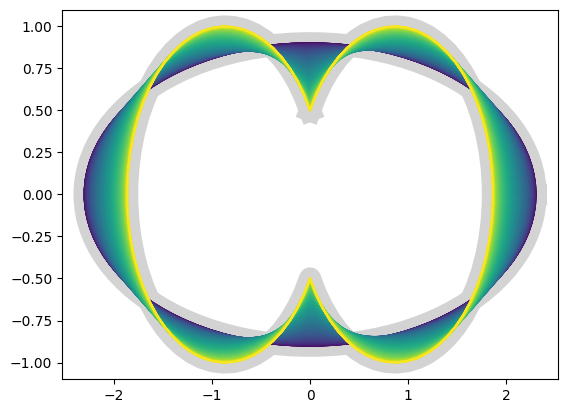

In [4]:
n = 100

x0 = 2.3*np.cos(np.linspace(0, 2*np.pi, n)).round(12)
y0 = 0.9*np.sin(np.linspace(0, 2*np.pi, n)).round(12)

x1 = np.cos(np.linspace(1/6*np.pi, 11/6*np.pi, n//2)) - 0.5*3**0.5
y1 = np.sin(np.linspace(1/6*np.pi, 11/6*np.pi, n//2))
x1 = np.concatenate([x1, -np.flip(x1)]).round(12)
y1 = np.concatenate([y1, np.flip(y1)]).round(12)

plt.plot(x0, y0, linewidth=16, zorder=0, color='lightgrey')
plt.plot(x1, y1, linewidth=16, zorder=0, color='lightgrey')

cmap = plt.get_cmap()

stages = get_stage(np.transpose([x0, y0]), np.transpose([x1, y1]), np.linspace(0, 1, 101))

for i, stage in enumerate(stages):
    xr, yr = stage.transpose()
    plt.plot(xr, yr, color=cmap(i/stages.shape[0]), zorder=1)

## Curvy Circles

In [5]:
f = lambda t: 0.5*(1 - np.cos(np.pi*t))
f = lambda t: np.sin(0.5*np.pi*t)**2

def curvy_radius(phi, angles=[0], radiuses=[1], f=lambda t: np.sin(0.5*np.pi*t)**2):
    """
    """
    phi = np.asarray(phi)
    angles = np.asarray(angles)
    radiuses = np.asarray(radiuses)

    angles = angles%(2*np.pi)
    radiuses = radiuses[np.argsort(angles)]
    angles = np.sort(angles)
    
    angle0, angle1 = angles[[0, -1]]
    radius0, radius1 = radiuses[[0, -1]]
    angles = np.concatenate([[angle1 - 2*np.pi], angles, [angle0 + 2*np.pi]])
    radiuses = np.concatenate([[radius1], radiuses, [radius0]])

    phi = phi % (2*np.pi)
    res = np.nan*np.zeros(phi.shape)
    for i, ((a0, a1), (r0, r1)) in enumerate(zip(np.transpose([angles[:-1], angles[1:]]), 
                                                 np.transpose([radiuses[:-1], radiuses[1:]]))):
        p = (phi[(phi >= a0)&(phi <= a1)] - a0)/(a1 - a0)
        p = f(p)
        res[(phi >= a0)&(phi <= a1)] = (1 - p)*r0 + p*r1
    return res

In [6]:
n = 12
#angles = 2*np.pi*np.random.random(n)
angles = 2*np.pi*(np.arange(n) + np.random.random(n))/n
radiuses = 1 + 1*np.random.random(n)

phi = np.linspace(0, 2*np.pi, 25).reshape([5, -1])
r = curvy_radius(phi, angles, radiuses)
r

array([[1.94155962, 1.92627374, 1.87668707, 1.58529833, 1.41566641],
       [1.34264942, 1.46435547, 1.54850503, 1.61086809, 1.75464354],
       [1.80095864, 1.31798198, 1.1505895 , 1.16800463, 1.29140062],
       [1.43235342, 1.3549377 , 1.20448618, 1.32177041, 1.78245883],
       [1.71144655, 1.72054322, 1.93901019, 1.95797747, 1.94155962]])

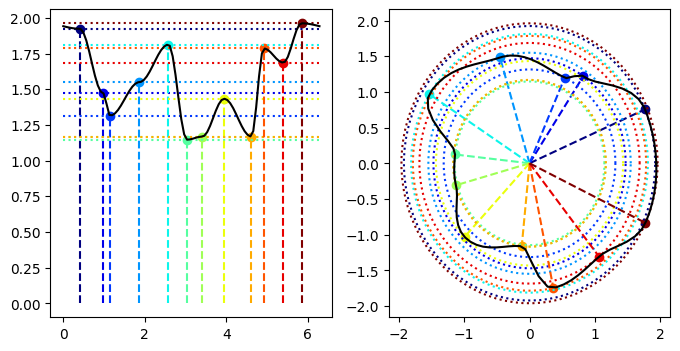

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

alpha = np.linspace(0, 2*np.pi, 90)

cmap = plt.get_cmap('jet')
for i, (angle, radius) in enumerate(zip(angles, radiuses)):
    color = cmap(i/(len(angles) - 1))

    axs[1].plot(radius*np.cos(np.linspace(0, 2*np.pi, 90)),  
                radius*np.sin(np.linspace(0, 2*np.pi, 90)), color=color, linestyle=':')
    axs[1].plot([0, radius*np.cos(angle)], 
                [0, radius*np.sin(angle)], color=color, linestyle='--')
    axs[1].scatter(radius*np.cos(angle), radius*np.sin(angle), color=color)

    axs[0].scatter(angle, radius, color=color)
    axs[0].plot([0, 2*np.pi], radius*np.ones(2), color=color, linestyle=':')
    axs[0].plot(angle*np.ones(2), [0, radius], color=color, linestyle='--')

phi = np.linspace(0, 2*np.pi, 90)
r = curvy_radius(phi, angles, radiuses)
axs[0].plot(phi, r, color='black')
axs[1].plot(r*np.cos(phi), r*np.sin(phi), color='black')


# Shape with 2 holes

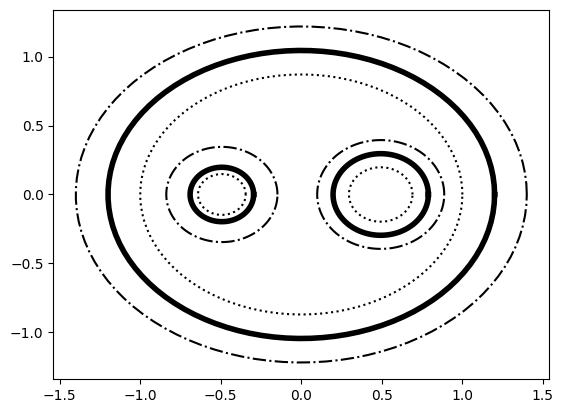

In [8]:
phi = np.linspace(0, 2*np.pi, 100)

# body
a = 1.0
b = 0.87

body_min_radius = 1
body_max_radius = 1.4
body_initial_radius = 1.2

plt.plot(a*body_max_radius*np.cos(phi), b*body_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(a*body_min_radius*np.cos(phi), b*body_min_radius*np.sin(phi), color='black', linestyle=':')

body_initial_curve = np.transpose([a*body_initial_radius*np.cos(phi), b*body_initial_radius*np.sin(phi)])
plt.plot(body_initial_curve[:, 0], body_initial_curve[:, 1], color='black', linestyle='-', linewidth=4)

# holes
c = body_min_radius*(a**2 - b**2)**0.5

# hole0
hole0_max_radius = c*0.7
hole0_min_radius = c*0.3
hole0_initial_radius = c*0.4

plt.plot(hole0_max_radius*np.cos(phi) - c, hole0_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(hole0_min_radius*np.cos(phi) - c, hole0_min_radius*np.sin(phi), color='black', linestyle=':')

hole0_initial_curve = np.transpose([hole0_initial_radius*np.cos(phi) - c, hole0_initial_radius*np.sin(phi)])
plt.plot(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='black', linestyle='-', linewidth=4)

# hole1
hole1_max_radius = c*0.8
hole1_min_radius = c*0.4
hole1_initial_radius = c*0.6

plt.plot(hole1_max_radius*np.cos(phi) + c, hole1_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(hole1_min_radius*np.cos(phi) + c, hole1_min_radius*np.sin(phi), color='black', linestyle=':')

hole1_initial_curve = np.transpose([hole1_initial_radius*np.cos(phi) + c, hole1_initial_radius*np.sin(phi)])
plt.plot(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='black', linestyle='-', linewidth=4)



In [9]:
stages = 12

# define the number of random vertices
min_n = 3
max_n = 13

body_ns = np.random.randint(min_n, max_n + 1, stages)
hole0_ns = np.random.randint(min_n, max_n + 1, stages)
hole1_ns = np.random.randint(min_n, max_n + 1, stages)

# body
body_radiuses = [body_min_radius + (body_max_radius - body_min_radius)*np.random.random(size=n) for n in body_ns]
body_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in body_ns]
body_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(body_angles, body_radiuses)])
stage_body_curves = np.transpose([a*np.cos(phi)*body_curves_radius, 
                                  b*np.sin(phi)*body_curves_radius], (1, 2, 0))

# hole0
hole0_radiuses = [hole0_min_radius + (hole0_max_radius - hole0_min_radius)*np.random.random(size=n) for n in hole0_ns]
hole0_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in hole0_ns]
hole0_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(hole0_angles, hole0_radiuses)])
stage_hole0_curves = np.transpose([-c + np.cos(phi)*hole0_curves_radius, 
                                   np.sin(phi)*hole0_curves_radius], (1, 2, 0))

# hole1
hole1_radiuses = [hole1_min_radius + (hole1_max_radius - hole1_min_radius)*np.random.random(size=n) for n in hole1_ns]
hole1_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in hole1_ns]
hole1_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(hole1_angles, hole1_radiuses)])
stage_hole1_curves = np.transpose([c + np.cos(phi)*hole1_curves_radius, 
                                   np.sin(phi)*hole1_curves_radius], (1, 2, 0))

# add initial stages
stage_body_curves = np.concatenate([[body_initial_curve], stage_body_curves])
stage_hole0_curves = np.concatenate([[hole0_initial_curve], stage_hole0_curves])
stage_hole1_curves = np.concatenate([[hole1_initial_curve], stage_hole1_curves])

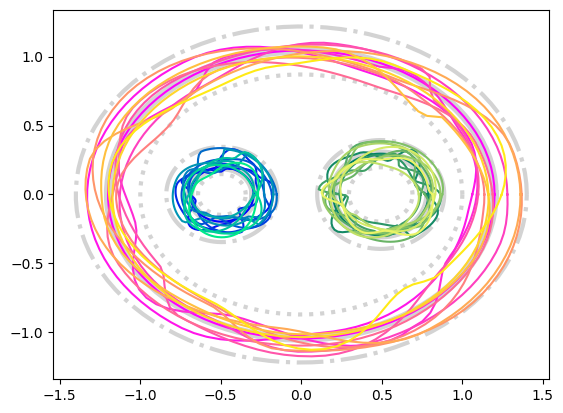

In [10]:
plt.plot(a*body_max_radius*np.cos(phi), b*body_max_radius*np.sin(phi), color='lightgrey', linestyle='-.', linewidth=3)
plt.plot(a*body_min_radius*np.cos(phi), b*body_min_radius*np.sin(phi), color='lightgrey', linestyle=':', linewidth=3)
plt.plot(body_initial_curve[:, 0], body_initial_curve[:, 1], color='lightgrey', linestyle='-', linewidth=6)

plt.plot(hole0_max_radius*np.cos(phi) - c, hole0_max_radius*np.sin(phi), color='lightgrey', linestyle='-.', linewidth=3)
plt.plot(hole0_min_radius*np.cos(phi) - c, hole0_min_radius*np.sin(phi), color='lightgrey', linestyle=':', linewidth=3)
plt.plot(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='lightgrey', linestyle='-', linewidth=6)

plt.plot(hole1_max_radius*np.cos(phi) + c, hole1_max_radius*np.sin(phi), color='lightgrey', linestyle='-.', linewidth=3)
plt.plot(hole1_min_radius*np.cos(phi) + c, hole1_min_radius*np.sin(phi), color='lightgrey', linestyle=':', linewidth=3)
plt.plot(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='lightgrey', linestyle='-', linewidth=6)



cmap_body = plt.get_cmap('spring')
cmap_hole0 = plt.get_cmap('winter')
cmap_hole1 = plt.get_cmap('summer')
for i in range(stages):
    x = stage_body_curves[i, :, 0]
    y = stage_body_curves[i, :, 1]
    plt.plot(x, y, color=cmap_body(i/stages))

    x = stage_hole0_curves[i, :, 0]
    y = stage_hole0_curves[i, :, 1]
    plt.plot(x, y, color=cmap_hole0(i/stages))

    x = stage_hole1_curves[i, :, 0]
    y = stage_hole1_curves[i, :, 1]
    plt.plot(x, y, color=cmap_hole1(i/stages))


In [11]:
def rotate_points(points, angles, center):
    n, m, _ = points.shape  # Extract dimensions
    rotated_points = np.zeros_like(points)  # Initialize output array
    
    # Translate points so that `center` becomes the origin
    points_shifted = points - center  # Shape (n, m, 2)
    
    # Compute cos and sin of angles, reshaped for broadcasting
    cos_a = np.cos(angles).reshape(n, 1)  # Shape (n, 1)
    sin_a = np.sin(angles).reshape(n, 1)  # Shape (n, 1)

    # Apply rotation matrix
    x_new = cos_a * points_shifted[..., 0] - sin_a * points_shifted[..., 1]
    y_new = sin_a * points_shifted[..., 0] + cos_a * points_shifted[..., 1]

    # Reconstruct rotated points
    rotated_points[..., 0] = x_new + center[0]
    rotated_points[..., 1] = y_new + center[1]

    return rotated_points

In [12]:
n_between_stages = 25

t = np.linspace(0, 1, n_between_stages)

body_curves = np.concatenate([get_stage(stage_body_curves[i], stage_body_curves[(i + 1)%stages], t) for i in range(stages)])
hole0_curves = np.concatenate([get_stage(stage_hole0_curves[i], stage_hole0_curves[(i + 1)%stages], t) for i in range(stages)])
hole1_curves = np.concatenate([get_stage(stage_hole1_curves[i], stage_hole1_curves[(i + 1)%stages], t) for i in range(stages)])

# rotate
angles = np.linspace(0, 2*np.pi, body_curves.shape[0])
center = np.array([-1.0, -0.5])
body_curves = rotate_points(body_curves, angles, center)
hole0_curves = rotate_points(hole0_curves, angles, center)
hole1_curves = rotate_points(hole1_curves, angles, center)


print(f'body_curves.shape={body_curves.shape}')
print(f'hole0_curves.shape={hole0_curves.shape}')
print(f'hole1_curves.shape={hole1_curves.shape}')

body_curves.shape=(300, 100, 2)
hole0_curves.shape=(300, 100, 2)
hole1_curves.shape=(300, 100, 2)


In [13]:
path_template = 'pics/body_with_2_holes_continuous/body_with_2_holes_continuous-{0}.png'

images = []
for i in tqdm(range(body_curves.shape[0]), total=body_curves.shape[0]):
    x = body_curves[i, :, 0]
    y = body_curves[i, :, 1]

    fig, ax = plt.subplots(figsize=(4, 3))
    
    
    ax.fill(x, y, color='sandybrown')

    x = hole0_curves[i, :, 0]
    y = hole0_curves[i, :, 1]
    ax.fill(x, y, color='white')

    x = hole1_curves[i, :, 0]
    y = hole1_curves[i, :, 1]
    ax.fill(x, y, color='white')

    ax.axis('off')

    plt.savefig(path_template.format(i))
    plt.close()


  0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
images = [io.imread(path_template.format(i)) for i in tqdm(range(body_curves.shape[0]), total=body_curves.shape[0])]

filename = f'gifs/body_with_2_holes_continuous.gif'
io.mimsave(filename, images, fps=24, loop=0)

print(f'Generated and saved to path {filename}')

  0%|          | 0/300 [00:00<?, ?it/s]

/tmp/ipykernel_8084/3651608429.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(path_template.format(i)) for i in tqdm(range(body_curves.shape[0]), total=body_curves.shape[0])]


Generated and saved to path gifs/body_with_2_holes_continuous.gif


## Circles around holes

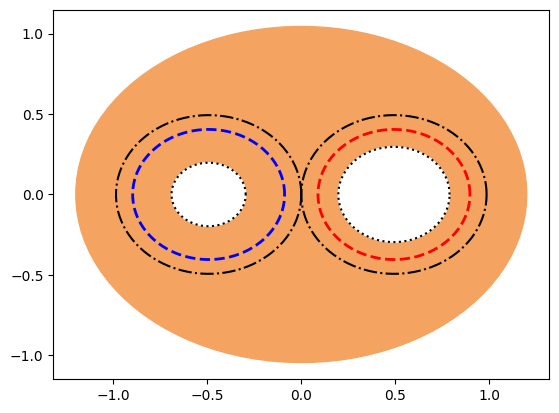

In [15]:
surround_hole0_min_radius = hole0_initial_radius
surround_hole1_min_radius = hole1_initial_radius

surround_hole0_max_radius = c
surround_hole1_max_radius = c

surround_hole0_initial_radius = 0.3*surround_hole0_min_radius + 0.7*surround_hole0_max_radius
surround_hole1_initial_radius = 0.1*surround_hole1_min_radius + 0.9*surround_hole1_max_radius


plt.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
plt.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
plt.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

plt.plot(surround_hole0_max_radius*np.cos(phi) - c, surround_hole0_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(surround_hole0_min_radius*np.cos(phi) - c, surround_hole0_min_radius*np.sin(phi), color='black', linestyle=':')

plt.plot(surround_hole1_max_radius*np.cos(phi) + c, surround_hole1_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(surround_hole1_min_radius*np.cos(phi) + c, surround_hole1_min_radius*np.sin(phi), color='black', linestyle=':')

surround_hole0_initial_curve = np.transpose([surround_hole0_initial_radius*np.cos(phi) - c, surround_hole0_initial_radius*np.sin(phi)])
surround_hole1_initial_curve = np.transpose([surround_hole0_initial_radius*np.cos(phi) + c, surround_hole0_initial_radius*np.sin(phi)])

plt.plot(surround_hole0_initial_curve[:, 0], surround_hole0_initial_curve[:, 1], color='blue', linewidth=2, linestyle='--')
plt.plot(surround_hole1_initial_curve[:, 0], surround_hole1_initial_curve[:, 1], color='red', linewidth=2, linestyle='--')

In [16]:
stages = 8

# define the number of random vertices
min_n = 1
max_n = 7

surround_hole0_ns = np.random.randint(min_n, max_n + 1, stages)
surround_hole1_ns = np.random.randint(min_n, max_n + 1, stages)

# hole0
surround_hole0_radiuses = [surround_hole0_min_radius + (surround_hole0_max_radius - surround_hole0_min_radius)*np.random.random(size=n) for n in surround_hole0_ns]
surround_hole0_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in surround_hole0_ns]
surround_hole0_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(surround_hole0_angles, surround_hole0_radiuses)])
stage_surround_hole0_curves = np.transpose([-c + np.cos(phi)*surround_hole0_curves_radius, 
                                            np.sin(phi)*surround_hole0_curves_radius], (1, 2, 0))

# hole1
surround_hole1_radiuses = [surround_hole1_min_radius + (surround_hole1_max_radius - surround_hole1_min_radius)*np.random.random(size=n) for n in surround_hole1_ns]
surround_hole1_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in surround_hole1_ns]
surround_hole1_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(surround_hole1_angles, surround_hole1_radiuses)])
stage_surround_hole1_curves = np.transpose([c + np.cos(phi)*surround_hole1_curves_radius, 
                                            np.sin(phi)*surround_hole1_curves_radius], (1, 2, 0))

# add initial
stage_surround_hole0_curves = np.concatenate([[surround_hole0_initial_curve], stage_surround_hole0_curves])
stage_surround_hole1_curves = np.concatenate([[surround_hole1_initial_curve], stage_surround_hole1_curves])

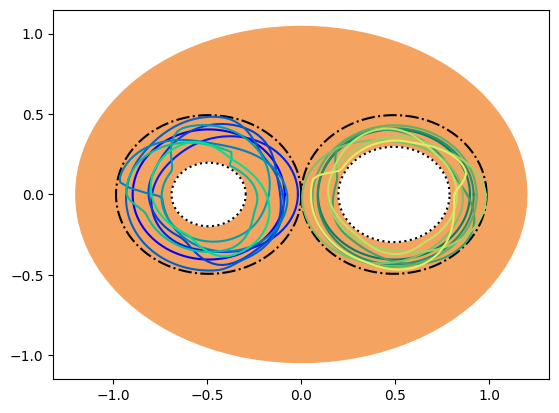

In [17]:
plt.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
plt.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
plt.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

plt.plot(surround_hole0_max_radius*np.cos(phi) - c, surround_hole0_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(surround_hole0_min_radius*np.cos(phi) - c, surround_hole0_min_radius*np.sin(phi), color='black', linestyle=':')

plt.plot(surround_hole1_max_radius*np.cos(phi) + c, surround_hole1_max_radius*np.sin(phi), color='black', linestyle='-.')
plt.plot(surround_hole1_min_radius*np.cos(phi) + c, surround_hole1_min_radius*np.sin(phi), color='black', linestyle=':')

for i in range(stages):
    x = stage_surround_hole0_curves[i, :, 0]
    y = stage_surround_hole0_curves[i, :, 1]
    plt.plot(x, y, color=cmap_hole0(i/stages))

    x = stage_surround_hole1_curves[i, :, 0]
    y = stage_surround_hole1_curves[i, :, 1]
    plt.plot(x, y, color=cmap_hole1(i/stages))


In [18]:
n_between_stages = 25

t = np.linspace(0, 1, n_between_stages)

surround_hole0_curves = np.concatenate([get_stage(stage_surround_hole0_curves[i], stage_surround_hole0_curves[(i + 1)%stages], t) for i in range(stages)])
surround_hole1_curves = np.concatenate([get_stage(stage_surround_hole1_curves[i], stage_surround_hole1_curves[(i + 1)%stages], t) for i in range(stages)])


print(f'surround_hole0_curves.shape={surround_hole0_curves.shape}')
print(f'surround_hole0_curves.shape={surround_hole0_curves.shape}')

surround_hole0_curves.shape=(200, 100, 2)
surround_hole0_curves.shape=(200, 100, 2)


In [19]:
path_template = 'pics/body_with_2_holes_surround_circles/body_with_2_holes_surround_circles-{0}.png'

for i in tqdm(range(surround_hole0_curves.shape[0]), total=surround_hole0_curves.shape[0]):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
    ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
    ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

    x = surround_hole0_curves[i, :, 0]
    y = surround_hole0_curves[i, :, 1]
    ax.plot(x, y, color='blue', linewidth=2, linestyle='--')

    x = surround_hole1_curves[i, :, 0]
    y = surround_hole1_curves[i, :, 1]
    ax.plot(x, y, color='red', linewidth=2, linestyle='--')

    ax.axis('off')

    plt.savefig(path_template.format(i))
    plt.close()


  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
images = [io.imread(path_template.format(i)) for i in tqdm(range(surround_hole0_curves.shape[0]), total=surround_hole0_curves.shape[0])]

filename = f'gifs/body_with_2_holes_surround_circles.gif'
io.mimsave(filename, images, fps=24, loop=0)

print(f'Generated and saved to path {filename}')

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_8084/1678081962.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(path_template.format(i)) for i in tqdm(range(surround_hole0_curves.shape[0]), total=surround_hole0_curves.shape[0])]


Generated and saved to path gifs/body_with_2_holes_surround_circles.gif


## Tightene circles

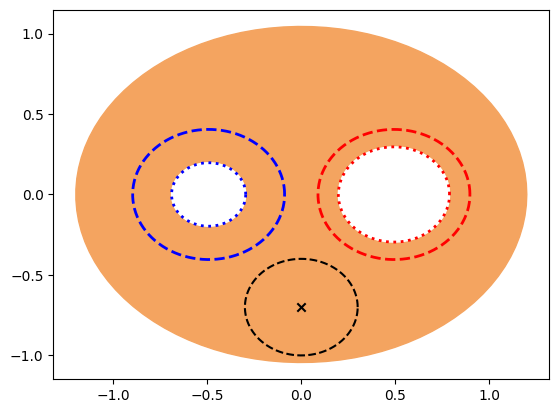

In [21]:
plt.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
plt.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
plt.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')


surround_hole0_min_curve = np.transpose([surround_hole0_min_radius*np.cos(phi) - c, surround_hole0_min_radius*np.sin(phi)])
surround_hole1_min_curve = np.transpose([surround_hole1_min_radius*np.cos(phi) + c, surround_hole1_min_radius*np.sin(phi)])

plt.plot(surround_hole0_initial_curve[:, 0], surround_hole0_initial_curve[:, 1], color='blue', linewidth=2, linestyle='--')
plt.plot(surround_hole0_min_curve[:, 0], surround_hole0_min_curve[:, 1], color='blue', linewidth=2, linestyle=':')

plt.plot(surround_hole1_initial_curve[:, 0], surround_hole1_initial_curve[:, 1], color='red', linewidth=2, linestyle='--')
plt.plot(surround_hole1_min_curve[:, 0], surround_hole1_min_curve[:, 1], color='red', linewidth=2, linestyle=':')



tightinable_center = np.array([0.0, -0.7])
tightinable_max_radius = 0.3
tightinable_initial = tightinable_max_radius*np.transpose([np.cos(phi), np.sin(phi)]) + tightinable_center

plt.scatter(tightinable_center[0], tightinable_center[1], color='black', marker='x')
x, y = np.transpose(tightinable_initial)
plt.plot(x, y, color='black', linestyle='--')

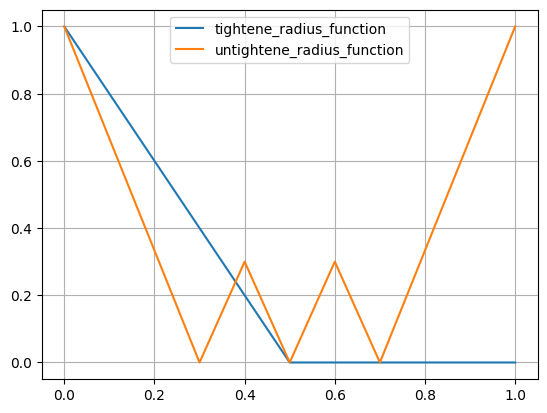

In [22]:
def tightene_radius_function(t, r0=1, r1=0, border=0.5):
    # 
    t = np.asarray(t)
    p = np.asarray(t/border)
    p[p >= 1] = 1
    res = (1 - p)*r0 + p*r1
    return res

def untightene_radius_function(t, r0=1, r1=0, peak_height=0.3):
    # 
    t = np.asarray(t)
    p = np.asarray(np.nan*t)
    p[t <= 0.3] = t[t <= 0.3]/0.3
    p[t >= 0.7] = (1 - t[t >= 0.7])/0.3

    p[(t >= 0.3)&(t <= 0.4)] = (t[(t >= 0.3)&(t <= 0.4)] - 0.3)/0.1
    p[(t >= 0.4)&(t <= 0.5)] = (0.5 - t[(t >= 0.4)&(t <= 0.5)])/0.1
    
    p[(t >= 0.5)&(t <= 0.6)] = (t[(t >= 0.5)&(t <= 0.6)] - 0.5)/0.1
    p[(t >= 0.6)&(t <= 0.7)] = (0.7 - t[(t >= 0.6)&(t <= 0.7)])/0.1
    
    p[(t >= 0.3)&(t <= 0.7)] = 1 - peak_height*p[(t >= 0.3)&(t <= 0.7)]
    
    res = (1 - p)*r0 + p*r1
    return res


t = np.linspace(0, 1, 101)
for f in [tightene_radius_function, untightene_radius_function]:
    plt.plot(t, f(t), label=f.__name__)
plt.legend()
plt.grid(True)
plt.show()

In [23]:
path_template = 'pics/body_with_2_holes_tightene_circles/body_with_2_holes_tightene_circles-{0}.png'

ts = np.linspace(0, 1, 100)

for i, t in tqdm(enumerate(ts), total=len(ts)):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
    ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
    ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

    # surround hole0
    r = untightene_radius_function(t, r0=surround_hole0_initial_radius, r1=surround_hole0_min_radius)
    x = r*np.cos(phi) - c
    y = r*np.sin(phi)
    plt.plot(x, y, color='blue', linewidth=2, linestyle='--')

    # surround hole1
    r = untightene_radius_function(t, r0=surround_hole1_initial_radius, r1=surround_hole1_min_radius)
    x = r*np.cos(phi) + c
    y = r*np.sin(phi)
    plt.plot(x, y, color='red', linewidth=2, linestyle='--')

    # tightened
    r = tightene_radius_function(t, r0=tightinable_max_radius, r1=0)
    x = r*np.cos(phi) + tightinable_center[0]
    y = r*np.sin(phi) + tightinable_center[1]
    plt.plot(x, y, color='black', linewidth=2, linestyle='--')

    if r == 0:
        plt.scatter(tightinable_center[0], tightinable_center[1], marker='x', color='black')

    ax.axis('off')

    plt.savefig(path_template.format(i))
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
images = [io.imread(path_template.format(i)) for i, t in tqdm(enumerate(ts), total=len(ts))]
          
filename = f'gifs/body_with_2_holes_tightene_circles.gif'
io.mimsave(filename, images, fps=24, loop=0)

print(f'Generated and saved to path {filename}')

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_8084/4071161478.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(path_template.format(i)) for i, t in tqdm(enumerate(ts), total=len(ts))]


Generated and saved to path gifs/body_with_2_holes_tightene_circles.gif


## 3 circles

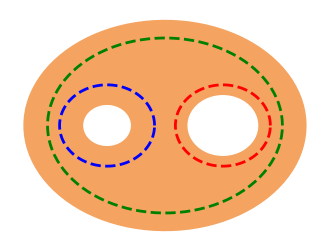

In [25]:
path = 'pics/body_with_2_holes_and_3_circles.png'

fig, ax = plt.subplots(figsize=(4, 3))

ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

plt.plot(surround_hole0_initial_curve[:, 0], surround_hole0_initial_curve[:, 1], color='blue', linewidth=2, linestyle='--')
plt.plot(surround_hole1_initial_curve[:, 0], surround_hole1_initial_curve[:, 1], color='red', linewidth=2, linestyle='--')

surround_body_initial_curve = np.transpose([a*body_min_radius*np.cos(phi), b*body_min_radius*np.sin(phi)])
plt.plot(surround_body_initial_curve[:, 0], surround_body_initial_curve[:, 1], color='green', linewidth=2, linestyle='--')

ax.axis('off')

plt.savefig(path)

## 3 directed circles

In [26]:
body_initial_curve.shape, hole0_initial_curve.shape, hole1_initial_curve.shape

((100, 2), (100, 2), (100, 2))

In [27]:
def get_direction(curve):
    # 
    x = np.concatenate([curve, [curve[0]]])
    d = x[1:] - x[:-1]
    d = d/np.linalg.norm(d, axis=1).reshape((len(d), 1))
    return d

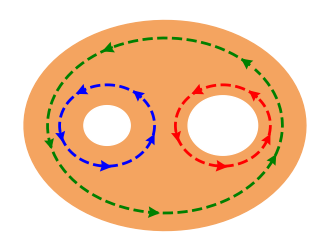

In [28]:
path = 'pics/body_with_2_and_3_directed_circles.png'
space = 100//5


i = 12

body_plot = np.concatenate([surround_body_initial_curve[i:], surround_body_initial_curve[:i]])
hole0_plot = np.concatenate([surround_hole0_initial_curve[i:], surround_hole0_initial_curve[:i]])
hole1_plot = np.concatenate([surround_hole1_initial_curve[i:], surround_hole1_initial_curve[:i]])

body_direction = get_direction(body_plot)
hole0_direction = get_direction(hole0_plot)
hole1_direction = get_direction(hole1_plot)

fig, ax = plt.subplots(figsize=(4, 3))

ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

ax.plot(hole0_plot[:, 0], hole0_plot[:, 1], color='blue', linewidth=2, linestyle='--')
ax.plot(hole1_plot[:, 0], hole1_plot[:, 1], color='red', linewidth=2, linestyle='--')
ax.plot(body_plot[:, 0], body_plot[:, 1], color='green', linewidth=2, linestyle='--')
    
ax.quiver(hole0_plot[::space, 0], hole0_plot[::space, 1], hole0_direction[::space, 0], hole0_direction[::space, 1], 
          angles='xy', scale_units='xy', scale=10, headwidth=5, color='blue')
ax.quiver(hole1_plot[::space, 0], hole1_plot[::space, 1], hole1_direction[::space, 0], hole1_direction[::space, 1], 
          angles='xy', scale_units='xy', scale=10, headwidth=5, color='red')
ax.quiver(body_plot[::space, 0], body_plot[::space, 1], body_direction[::space, 0], body_direction[::space, 1], 
          angles='xy', scale_units='xy', scale=10, headwidth=5, color='green')
    
ax.axis('off')

plt.savefig(path)
plt.show()

# Sum 2 cycles

cycle0_initial.shape = (100, 2)
cycle0_initial.shape = (100, 2)
cycle0_finish_curve.shape = (100, 2)
cycle1_finish_curve.shape = (100, 2)
cycle2_initial.shape = (200, 2)
cycle2_finish_curve.shape = (200, 2)


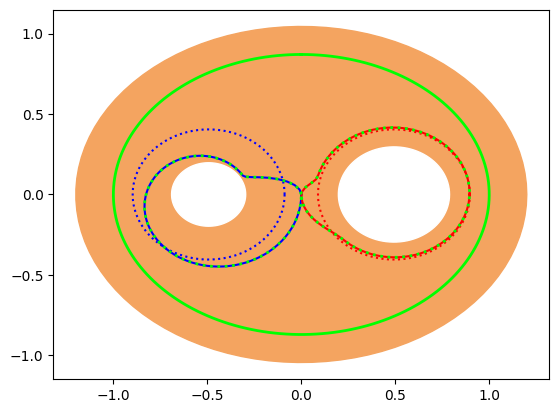

In [29]:
cycle0_initial = surround_hole0_initial_curve
cycle1_initial = surround_hole1_initial_curve


# define finishing position
min_finish_n = 1
max_finish_n = 6

cycle0_finish_n = np.random.randint(min_finish_n, max_finish_n)
cycle1_finish_n = np.random.randint(min_finish_n, max_finish_n)

cycle0_finish_radiuses = surround_hole0_min_radius + (surround_hole0_max_radius - surround_hole0_min_radius)*np.random.random(size=cycle0_finish_n)
cycle0_finish_angles = 2*np.pi*(np.arange(cycle0_finish_n) + np.random.random(cycle0_finish_n))/cycle0_finish_n
cycle0_finish_radiuses = np.append(cycle0_finish_radiuses, c)
cycle0_finish_angles = np.append(cycle0_finish_angles, 0)
cycle0_finish_curves_radius = curvy_radius(phi, cycle0_finish_angles, cycle0_finish_radiuses)
cycle0_finish_curve = np.transpose([-c + np.cos(phi)*cycle0_finish_curves_radius, np.sin(phi)*cycle0_finish_curves_radius])

cycle1_finish_radiuses = surround_hole1_min_radius + (surround_hole1_max_radius - surround_hole1_min_radius)*np.random.random(size=cycle1_finish_n)
cycle1_finish_angles = 2*np.pi*(np.arange(cycle1_finish_n) + np.random.random(cycle1_finish_n))/cycle1_finish_n
cycle1_finish_radiuses = np.append(cycle1_finish_radiuses, c)
cycle1_finish_angles = np.append(cycle1_finish_angles, np.pi)
cycle1_finish_curves_radius = curvy_radius(phi, cycle1_finish_angles, cycle1_finish_radiuses)
cycle1_finish_curve = np.transpose([+c + np.cos(phi)*cycle1_finish_curves_radius, np.sin(phi)*cycle1_finish_curves_radius])


# outer initial
cycle2_initial = np.concatenate([
    cycle0_finish_curve, 
    cycle1_finish_curve[len(cycle1_finish_curve)//2:], 
    cycle1_finish_curve[:len(cycle1_finish_curve)//2]
    
])

large_phi = np.linspace(0.5*np.pi, 2.5*np.pi, len(cycle2_initial))
cycle2_finish_curve = np.transpose([a*np.cos(large_phi), b*np.sin(large_phi)])


plt.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
plt.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
plt.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

plt.plot(cycle0_initial[:, 0], cycle0_initial[:, 1], color='blue', linestyle=':')
plt.plot(cycle1_initial[:, 0], cycle1_initial[:, 1], color='red', linestyle=':')

plt.plot(cycle0_finish_curve[:, 0], cycle0_finish_curve[:, 1], color='blue')
plt.plot(cycle1_finish_curve[:, 0], cycle1_finish_curve[:, 1], color='red')

plt.plot(cycle2_initial[:, 0], cycle2_initial[:, 1], color='lime', linestyle=':', linewidth=2)
plt.plot(cycle2_finish_curve[:, 0], cycle2_finish_curve[:, 1], color='lime', linestyle='-', linewidth=2)



print(f'cycle0_initial.shape = {cycle0_initial.shape}')
print(f'cycle0_initial.shape = {cycle0_initial.shape}')
print(f'cycle0_finish_curve.shape = {cycle0_finish_curve.shape}')
print(f'cycle1_finish_curve.shape = {cycle1_finish_curve.shape}')
print(f'cycle2_initial.shape = {cycle2_initial.shape}')
print(f'cycle2_finish_curve.shape = {cycle2_finish_curve.shape}')

stage_cycle0_curves.shape = (2, 100, 2)
stage_cycle1_curves.shape = (2, 100, 2)
stage_cycle2_curves.shape = (2, 200, 2)


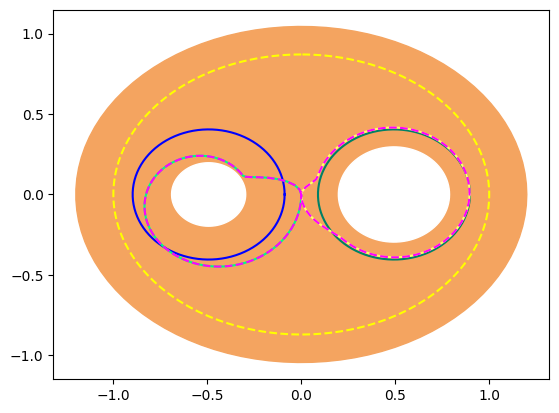

In [30]:
stages_before_gluing = 0
stages_after_gluing = 0


# cycle0
if stages_before_gluing > 0:
    cycle0_ns = np.random.randint(2, 8, size=stages_before_gluing)
    cycle0_radiuses = [surround_hole0_min_radius + (surround_hole0_max_radius - surround_hole0_min_radius)*np.random.random(size=n) for n in cycle0_ns]
    cycle0_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in cycle0_ns]
    cycle0_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(cycle0_angles, cycle0_radiuses)])
    stage_cycle0_curves = np.transpose([-c + np.cos(phi)*cycle0_curves_radius, 
                                  np.sin(phi)*cycle0_curves_radius], (1, 2, 0))
    stage_cycle0_curves = np.concatenate([[cycle0_initial], stage_cycle0_curves, [cycle0_finish_curve], ])
else:
    stage_cycle0_curves = np.concatenate([[cycle0_initial], [cycle0_finish_curve], ])
    
print(f'stage_cycle0_curves.shape = {stage_cycle0_curves.shape}')

# cycle1
if stages_before_gluing > 0:
    cycle1_ns = np.random.randint(2, 8, size=stages_before_gluing)
    cycle1_radiuses = [surround_hole1_min_radius + (surround_hole1_max_radius - surround_hole0_min_radius)*np.random.random(size=n) for n in cycle1_ns]
    cycle1_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in cycle1_ns]
    cycle1_curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(cycle1_angles, cycle1_radiuses)])
    stage_cycle1_curves = np.transpose([+c + np.cos(phi)*cycle1_curves_radius, 
                                  np.sin(phi)*cycle1_curves_radius], (1, 2, 0))
    stage_cycle1_curves = np.concatenate([[cycle1_initial], stage_cycle1_curves, [cycle1_finish_curve], ])
else:
    stage_cycle1_curves = np.concatenate([[cycle1_initial], [cycle1_finish_curve], ])
print(f'stage_cycle1_curves.shape = {stage_cycle1_curves.shape}')

# cycle2
if stages_after_gluing > 0:
    cycle2_ns = np.random.randint(2, 8, size=stages_after_gluing)
    cycle2_radiuses = [body_min_radius + (body_initial_radius - body_min_radius)*np.random.random(size=n) for n in cycle2_ns]
    cycle2_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in cycle2_ns]
    cycle2_curves_radius = np.array([curvy_radius(large_phi, angles, radiuses) for angles, radiuses in zip(cycle2_angles, cycle2_radiuses)])
    stage_cycle2_curves = np.transpose([a*np.cos(large_phi)*cycle2_curves_radius, 
                                  b*np.sin(large_phi)*cycle2_curves_radius], (1, 2, 0))
    stage_cycle2_curves = np.concatenate([[cycle2_initial], stage_cycle2_curves, [cycle2_finish_curve], ])
else:
    stage_cycle2_curves = np.concatenate([[cycle2_initial], [cycle2_finish_curve], ])
print(f'stage_cycle2_curves.shape = {stage_cycle2_curves.shape}')


plt.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
plt.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
plt.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

cmap_cycle0 = plt.get_cmap('winter')
cmap_cycle1 = plt.get_cmap('summer')
cmap_cycle2 = plt.get_cmap('spring')
for i in range(stages_before_gluing + 2):
    i_val = i/(stages_before_gluing + 1)
    x = stage_cycle0_curves[i, :, 0]
    y = stage_cycle0_curves[i, :, 1]
    plt.plot(x, y, color=cmap_cycle0(i_val))

    x = stage_cycle1_curves[i, :, 0]
    y = stage_cycle1_curves[i, :, 1]
    plt.plot(x, y, color=cmap_cycle1(i_val))
for i in range(stages_after_gluing + 2):
    i_val = i/(stages_after_gluing + 1)
    x = stage_cycle2_curves[i, :, 0]
    y = stage_cycle2_curves[i, :, 1]
    plt.plot(x, y, color=cmap_cycle2(i_val), linestyle='--')
plt.show()

In [31]:
n_between_stages_before_gluing = 25
n_between_stages_after_gluing = 40


t_before_gluing = np.linspace(0, 1, n_between_stages_before_gluing)
t_after_gluing = np.linspace(0, 1, n_between_stages_after_gluing)

stages = stage_cycle0_curves.shape[0]
cycle0_curves = np.concatenate([get_stage(stage_cycle0_curves[i], stage_cycle0_curves[(i + 1)%stages], t_before_gluing) for i in range(stages - 1)])

stages = stage_cycle1_curves.shape[0]
cycle1_curves = np.concatenate([get_stage(stage_cycle1_curves[i], stage_cycle1_curves[(i + 1)%stages], t_before_gluing) for i in range(stages - 1)])

stages = stage_cycle2_curves.shape[0]
cycle2_curves = np.concatenate([get_stage(stage_cycle2_curves[i], stage_cycle2_curves[(i + 1)%stages], t_after_gluing) for i in range(stages - 1)])

print(f'cycle0_curves.shape={cycle0_curves.shape}')
print(f'cycle1_curves.shape={cycle1_curves.shape}')
print(f'cycle2_curves.shape={cycle2_curves.shape}')

cycle0_curves.shape=(25, 100, 2)
cycle1_curves.shape=(25, 100, 2)
cycle2_curves.shape=(40, 200, 2)


In [32]:
path_template = 'pics/body_with_2_holes_sum_cycles/body_with_2_holes_sum_cycles-{0}.png'

space = 25


for i in tqdm(range(cycle0_curves.shape[0]), total=cycle0_curves.shape[0]):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
    ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
    ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

    x = cycle0_curves[i, :, 0]
    y = cycle0_curves[i, :, 1]
    xd, yd = get_direction(cycle0_curves[i]).transpose()
    
    ax.plot(x, y, color='blue', linewidth=2, linestyle='--')
    ax.quiver(x[::space], y[::space], xd[::space], yd[::space], 
              angles='xy', scale_units='xy', scale=10, headwidth=5, color='blue')

    x = cycle1_curves[i, :, 0]
    y = cycle1_curves[i, :, 1]
    xd, yd = get_direction(cycle1_curves[i]).transpose()
    
    ax.plot(x, y, color='red', linewidth=2, linestyle='--')
    ax.quiver(x[::space], y[::space], xd[::space], yd[::space], 
              angles='xy', scale_units='xy', scale=10, headwidth=5, color='red')

    ax.axis('off')

    plt.savefig(path_template.format(i))
    plt.close()

for i in tqdm(range(cycle2_curves.shape[0]), total=cycle2_curves.shape[0]):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ax.fill(body_initial_curve[:, 0], body_initial_curve[:, 1], color='sandybrown')
    ax.fill(hole0_initial_curve[:, 0], hole0_initial_curve[:, 1], color='white')
    ax.fill(hole1_initial_curve[:, 0], hole1_initial_curve[:, 1], color='white')

    x = cycle2_curves[i, :, 0]
    y = cycle2_curves[i, :, 1]
    xd, yd = get_direction(cycle2_curves[i]).transpose()
    ax.plot(x, y, color='purple', linewidth=2, linestyle='--')
    ax.quiver(x[::space], y[::space], xd[::space], yd[::space], 
              angles='xy', scale_units='xy', scale=10, headwidth=5, color='purple')

    ax.axis('off')

    plt.savefig(path_template.format(i + cycle0_curves.shape[0]))
    plt.close()



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
images = [io.imread(path_template.format(i)) for i in tqdm(range(cycle0_curves.shape[0] + cycle2_curves.shape[0]), total=cycle0_curves.shape[0] + cycle2_curves.shape[0])]
images = np.concatenate([images, images[::-1]])

filename = f'gifs/body_with_2_holes_sum_cycles.gif'
io.mimsave(filename, images, fps=24, loop=0)

print(f'Generated and saved to path {filename}')

  0%|          | 0/65 [00:00<?, ?it/s]

/tmp/ipykernel_8084/1574448882.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(path_template.format(i)) for i in tqdm(range(cycle0_curves.shape[0] + cycle2_curves.shape[0]), total=cycle0_curves.shape[0] + cycle2_curves.shape[0])]


Generated and saved to path gifs/body_with_2_holes_sum_cycles.gif


# Few bodies

## Body containtment

In [34]:
body0 = {
    'center': np.array([(0, 0), (0, 3.5)]), 
    'body radius': np.array([3, 2.5]), 
    'hole radius': np.array([1, 0.5]), 
    'multiplyers': [np.ones(2), np.ones(2)] 
}
body1 = {
    'center': np.array([(0, 0)]), 
    'body radius': np.array([2.5]), 
    'hole radius': np.array([0.5]), 
    'multiplyers': [(1.5, 1)] 
}
body2 = {
    'center': np.array([(0, 0)]), 
    'body radius': np.array([1]), 
    'hole radius': np.array([0]), 
    'multiplyers': [(1, 2)] 
}
body3 = {
    'center': np.array([(0, 0)]), 
    'body radius': np.array([2]), 
    'hole radius': np.array([0]), 
    'multiplyers': [np.ones(2)] 
}


bodies = [body0, body1, body2, body3]
adds = np.array([(0, 0), (-7, 4), (-5, -1), (-9, -1)])


## Plot body

In [35]:
def plot_body(body, add=np.zeros(2), phi=np.linspace(0, 2*np.pi, 100), ax=None, body_color='sandybrown', hole_color='white'):  
    #
    add = np.asarray(add)
    
    # 
    if ax is None:
        ax = plt.gca()

    # drow body
    for i in range(len(body['center'])):
        x = np.cos(phi)*body['body radius'][i]*body['multiplyers'][i][0] + body['center'][i][0] + add[0]
        y = np.sin(phi)*body['body radius'][i]*body['multiplyers'][i][1] + body['center'][i][1] + add[1]
        ax.fill(x, y, color=body_color)

    # drow holes
    for i in range(len(body['center'])):
        x = np.cos(phi)*body['hole radius'][i]*body['multiplyers'][i][0] + body['center'][i][0] + add[0]
        y = np.sin(phi)*body['hole radius'][i]*body['multiplyers'][i][1] + body['center'][i][1] + add[1]
        ax.fill(x, y, color=hole_color)

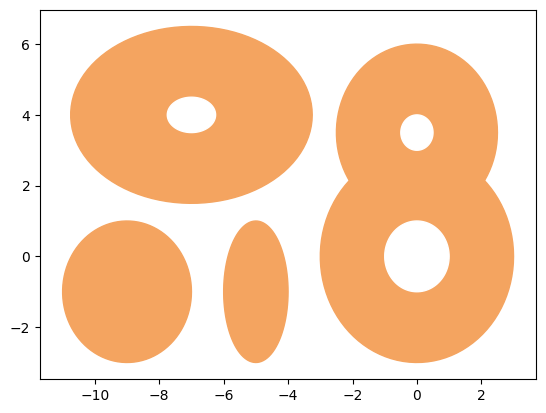

In [36]:
for body, add in zip(bodies, adds):
    plot_body(body=body, add=add)

## Reparameterize with constant derivative

In [37]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d

def reparameterize(f, t_range=(0, 1), num_samples=100):
    """
    Reparameterize f(t) -> (x, y) so that the speed is constant.
    
    Parameters:
        f : function
            A function that takes t and returns (x, y).
        t_range : tuple
            The range of t values (default is (0, 1)).
        num_samples : int
            Number of samples to compute the arc-length function.
    
    Returns:
        f_new : function
            The reparameterized function with constant speed.
    """
    t_values = np.linspace(*t_range, num_samples)
    xy_values = np.array([f(t) for t in t_values])
    
    # Compute the derivative (speed)
    dx_dt = np.gradient(xy_values[:, 0], t_values)
    dy_dt = np.gradient(xy_values[:, 1], t_values)
    speed = np.sqrt(dx_dt**2 + dy_dt**2)
    
    # Compute arc-length function
    s_values = np.concatenate([[0], np.cumsum(speed[:-1] * np.diff(t_values))])
    s_max = s_values[-1]
    s_values /= s_max  # Normalize to [0, 1]
    
    # Create inverse function t(s)
    t_of_s = interp1d(s_values, t_values, kind='linear', fill_value='extrapolate')
    
    # Define new function with constant speed
    def f_new(t):
        t_orig = t_of_s(t)
        return f(t_orig)
    
    return f_new

# Example usage
def f(t):
    return (np.sin(2 * np.pi * t), np.cos(2 * np.pi * t))

f_const_speed = reparameterize(f)

# Evaluate the new function at some points
new_points = np.array([f_const_speed(t) for t in np.linspace(0, 1, 10)])
print(new_points)

[[ 0.00000000e+00  1.00000000e+00]
 [ 6.42765841e-01  7.66062709e-01]
 [ 9.84803435e-01  1.73672664e-01]
 [ 8.66036060e-01 -4.99981543e-01]
 [ 3.42036833e-01 -9.39686546e-01]
 [-3.42006792e-01 -9.39697480e-01]
 [-8.66020076e-01 -5.00009229e-01]
 [-9.84808987e-01  1.73641181e-01]
 [-6.42790331e-01  7.66042160e-01]
 [-2.44929360e-16  1.00000000e+00]]


## Point trajectories

In [38]:
def get_trajectory_circular(r0, r1, 
                            angles=[0], values=[0.5], 
                            multiplyers=np.ones(2), center=np.zeros(2), 
                            angle0=0, 
                            f=lambda x: np.sin(0.5*np.pi*x)**2, rolls=1, 
                            do_reparameterize=True, num_samples=2000,
                           ):
    # returns the trajectory over the circular
    angles = np.asarray(angles)
    values = np.asarray(values)
    multiplyers = np.asarray(multiplyers)
    center = np.asarray(center)

    #angles = angles/(2*np.pi)
    values = values[np.argsort(angles)]
    angles = np.sort(angles)

    angles = np.concatenate([[angles[-1] - 2*np.pi], angles, [angles[0] + 2*np.pi]])
    values = np.concatenate([[values[-1]], values, [values[0]]])
    radiuses = r0 + values*(r1 - r0)

    def trajectory(t):
        t = np.asarray(t)
        original_shape = t.shape
        t = t.reshape(-1)
        
        t = (2*np.pi*t - angle0) % (2*np.pi)

        t_a0 = np.nan*t
        t_a1 = np.nan*t
        t_r0 = np.nan*t
        t_r1 = np.nan*t
        for i in range(len(angles) - 1):
            a0, a1 = angles[[i, i + 1]]
            r0, r1 = radiuses[[i, i + 1]]
            t_a0[(t >= a0)&(t <= a1)] = a0
            t_a1[(t >= a0)&(t <= a1)] = a1
            t_r0[(t >= a0)&(t <= a1)] = r0
            t_r1[(t >= a0)&(t <= a1)] = r1
        t_p = (t - t_a0)/(t_a1 - t_a0)
        t_p = f(t_p)
        t_r = t_r1*t_p + t_r0*(1 - t_p)
        
        res = np.transpose([t_r*np.cos(rolls*t), t_r*np.sin(rolls*t)])*multiplyers + center
        res = res.reshape(original_shape + (2, ))
        return res

    if do_reparameterize:
        return reparameterize(trajectory, num_samples=num_samples)

    return trajectory

In [39]:
def circle_intersections(c0: np.ndarray, c1: np.ndarray, r0: float, r1: float):
    # 
    d = np.linalg.norm(c1 - c0)
    
    if d > r0 + r1 or d < abs(r0 - r1) or d == 0:
        return None
    
    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h = np.sqrt(r0**2 - a**2)
    
    p2 = c0 + a * (c1 - c0) / d
    
    offset = np.array([-(c1[1] - c0[1]), c1[0] - c0[0]]) * (h / d)
    
    return p2 + offset, p2 - offset
    
def circle_intersections_angles(c0: np.ndarray, c1: np.ndarray, r0: float, r1: float):
    # 
    intersection0, intersection1 = circle_intersections(c0, c1, r0, r1)

    angle00 = intersection0 - c0
    angle00 = np.atan2(angle00[1], angle00[0])
    angle01 = intersection1 - c0
    angle01 = np.atan2(angle01[1], angle01[0])
    angle10 = intersection0 - c1
    angle10 = np.atan2(angle10[1], angle10[0])
    angle11 = intersection1 - c1
    angle11 = np.atan2(angle11[1], angle11[0])
    
    angles = np.array([angle00, angle01, angle10, angle11])
    #angles %= 2*np.pi
    return angles

In [40]:
def get_trajectory_eight(r00, r01, r10, r11, 
                         angles0=[0.0], angles1=[0.0], 
                         values0=[0.3], values1=[0.3], 
                         center0=np.zeros(2), center1=np.ones(2), 
                         angle0=0, f=lambda x: np.sin(0.5*np.pi*x)**2, 
                         do_reparameterize=True, num_samples=2000
                        ):
    # 
    angles0 = np.asarray(angles0)
    angles1 = np.asarray(angles1)
    values0 = np.asarray(values0)
    values1 = np.asarray(values1)
    center0 = np.asarray(center0)
    center1 = np.asarray(center1)

    angle_cross = center1 - center0
    angle_cross = np.atan2(angle_cross[1], angle_cross[0])

    trajectory0 = get_trajectory_circular(r0=r00, r1=r01, angles=angles0, values=values0, center=center0, angle0=2*np.pi - angle_cross, f=f, do_reparameterize=False)
    trajectory1 = get_trajectory_circular(r0=r10, r1=r11, angles=angles1, values=values1, center=center1, angle0=angle_cross, f=f, do_reparameterize=False)

    intersection_angles = circle_intersections_angles(c0=center0, c1=center1, r0=r01, r1=r11) - angle_cross
    intersection_angles[2:] += 2*angle_cross
    
    intersection_values = (intersection_angles) / (4*np.pi)
    intersection_values[[1, 3]] += 0.5
    intersection_values[[2, 3]] = intersection_values[[3, 2]]
    intersection_values %= 1
    
    def trajectory(t):
        t = np.asarray(t)
        original_shape = t.shape
        t = t.reshape(-1)
        
        t %= 1

        p = (t <= 0.5).astype(float)
        changing0 = (t < intersection_values[2])&(t > intersection_values[1])
        changing1 = (t < intersection_values[0])|(t > intersection_values[3])
        p[changing0] = 1 - (t[changing0] - intersection_values[1])/(intersection_values[2] - intersection_values[1])
        p[changing1] = ((t[changing1] - intersection_values[3])%1)/(1 + intersection_values[0] - intersection_values[3])
        p[changing0|changing1] = f(p[changing0|changing1])
        
        p = p.reshape([-1, 1])
        
        res = p*trajectory0(2*t) + (1 - p)*trajectory1(1 - 2*t)
        res = res.reshape(original_shape + (2, ))
        return res
        
    if do_reparameterize:
        return reparameterize(trajectory, num_samples=num_samples)
    
    return trajectory

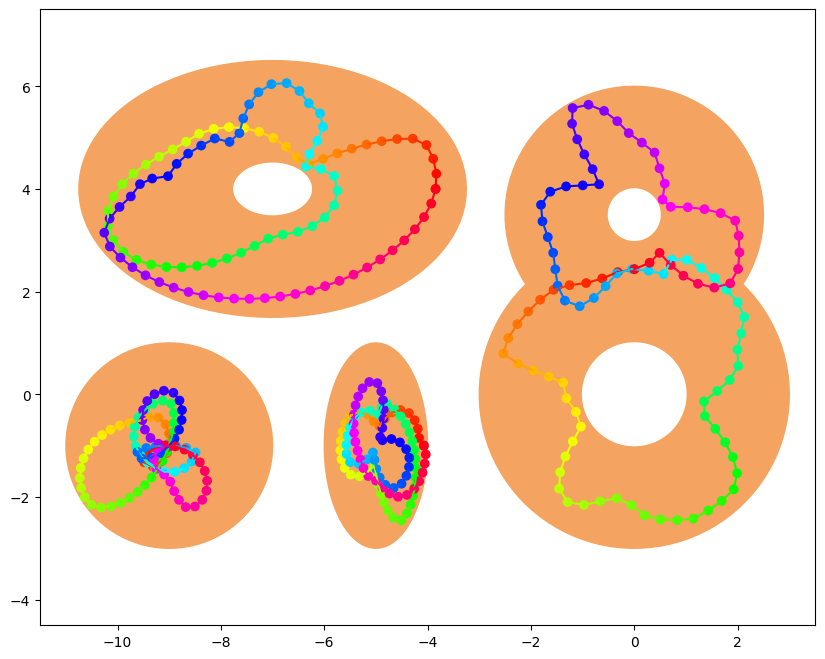

In [41]:
n00 = 15
n01 = 12
n1 = 15
n2 = 15
n3 = 12

point_trajectories = [
    get_trajectory_eight(r00=body0['hole radius'][0], r01=body0['body radius'][0], 
                         r10=body0['hole radius'][1], r11=body0['body radius'][1], 
                         center0=body0['center'][0] + adds[0], 
                         center1=body0['center'][1] + adds[0], 
                         angles0=2*np.pi*(np.arange(n00) + np.random.random(n00)) / n00,
                         values0=np.random.random(n00), 
                         angles1=2*np.pi*(np.arange(n01) + np.random.random(n01)) / n01,  
                         values1=np.random.random(n01), 
                        ), 
    get_trajectory_circular(r0=body1['hole radius'][0], 
                            r1=body1['body radius'][0], 
                            angles=2*np.pi*np.random.random(n1), 
                            values=(np.arange(n1) + np.random.random(n1)) / n1, 
                            center=body1['center'][0] + adds[1], 
                            multiplyers=body1['multiplyers'][0], rolls=2), 
    get_trajectory_circular(r0=body2['hole radius'][0], 
                            r1=body2['body radius'][0], 
                            angles= 2*np.pi*(np.arange(n2) + np.random.random(n2)) / n2, 
                            values= np.random.random(n2), 
                            center=body2['center'][0] + adds[2], 
                            multiplyers=body2['multiplyers'][0], rolls=3), 
    get_trajectory_circular(r0=-1.0*body3['body radius'][0], 
                            r1=+1.0*body3['body radius'][0], 
                            angles= 2*np.pi*(np.arange(n3) + np.random.random(n3)) / (n3), 
                            values= np.random.random(n3), 
                            center=body3['center'][0] + adds[3], 
                            multiplyers=body3['multiplyers'][0], rolls=3), 
]


plt.figure(figsize=(10, 8))
for body, add in zip(bodies, adds):
    plot_body(body=body, add=add)


cmap = plt.get_cmap('hsv')
for i in range(0, 4):
    trajectory = point_trajectories[i]
    t = np.linspace(0, 1, 100)
    x, y = trajectory(t).transpose()
    plt.scatter(x, y, color=cmap(t))
    for i, ti in enumerate(t):
        j = [i, (i+1)%len(t)]
        plt.plot(x[j], y[j], color=cmap(ti))
plt.xlim(-11.5, 3.5)
plt.ylim(-4.5, 7.5)
plt.show()

## Circle trajectories

In [42]:
def get_stages(phi, body_radiuses=None, body_angles=None, min_radius=0, max_radius=1, ns=[1], a=1, b=1):
    # 
    if body_radiuses is None:
        body_radiuses = [min_radius + (max_radius - min_radius)*np.random.random(size=n) for n in ns]
    if body_angles is None:
        body_angles = [2*np.pi*(np.arange(n) + np.random.random(n))/n for n in ns]
    curves_radius = np.array([curvy_radius(phi, angles, radiuses) for angles, radiuses in zip(body_angles, body_radiuses)])
    return  np.transpose([a*np.cos(phi)*curves_radius, 
                          b*np.sin(phi)*curves_radius], (1, 2, 0))

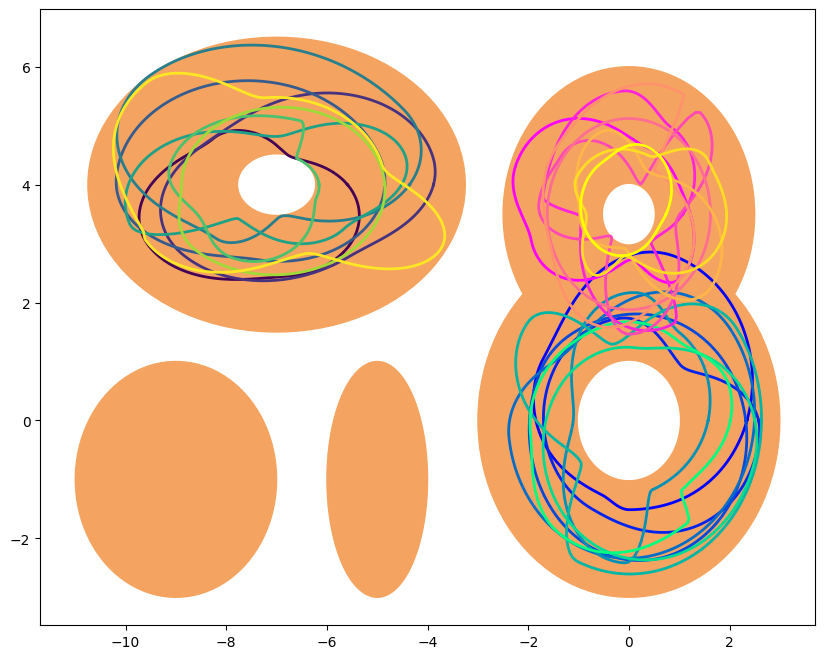

In [43]:
stages = 8

# define the number of random vertices
min_n = 1
max_n = 7

ns00 = np.random.randint(min_n, max_n + 1, stages)
ns01 = np.random.randint(min_n, max_n + 1, stages)
ns1 = np.random.randint(min_n, max_n + 1, stages)

phi = np.linspace(0, 2*np.pi, 200)

stage_curves00 = get_stages(phi, 
                            min_radius=body0['hole radius'][0], 
                            max_radius=body0['body radius'][0], ns=ns00, a=1, b=1) + body0['center'][0] + adds[0]
stage_curves01 = get_stages(phi, 
                            min_radius=body0['hole radius'][1], 
                            max_radius=body0['body radius'][1], ns=ns01, a=1, b=1) + body0['center'][1] + adds[0]
stage_curves1 = get_stages(phi, 
                           min_radius=body1['hole radius'][0],
                           max_radius=body1['body radius'][0], ns=ns00,
                           a=body1['multiplyers'][0][0], b=body1['multiplyers'][0][1]) + body1['center'][0] + adds[1]


cmaps = [plt.get_cmap('winter'), 
         plt.get_cmap('autumn'), 
         plt.get_cmap('summer'), 
        ]

plt.figure(figsize=(10, 8))
for body, add in zip(bodies, adds):
    plot_body(body=body, add=add)

for stage_curves, cmap in [(stage_curves00, plt.get_cmap('winter')), 
                           (stage_curves01, plt.get_cmap('spring')), 
                           (stage_curves1, plt.get_cmap('viridis'))]:
    for i, stage_curve in enumerate(stage_curves):
        color = cmap(i/(len(stage_curves) - 1))
        x, y = np.transpose(stage_curve)
        plt.plot(x, y, color=color, linewidth=2)

In [44]:
n_between_stages = 25

t = np.linspace(0, 1, n_between_stages)

curves00 = np.concatenate([get_stage(stage_curves00[i], stage_curves00[(i + 1)%stages], t) for i in range(stages)])
curves01 = np.concatenate([get_stage(stage_curves01[i], stage_curves01[(i + 1)%stages], t) for i in range(stages)])
curves1 = np.concatenate([get_stage(stage_curves1[i], stage_curves1[(i + 1)%stages], t) for i in range(stages)])

print(f'curves00.shape={curves00.shape}')
print(f'curves00.shape={curves01.shape}')
print(f'curves1.shape={curves1.shape}')

curves00.shape=(200, 200, 2)
curves00.shape=(200, 200, 2)
curves1.shape=(200, 200, 2)


## Animation

In [45]:
curves = np.array([curves00, curves01, curves1])

print(f'curves.shape={curves.shape}')

curves.shape=(3, 200, 200, 2)


In [46]:
path_template = 'pics/few_bodies/few_bodies-{0}.png'


frames = curves.shape[1]

circle_cmap = lambda t: plt.get_cmap('viridis')(0.1 + 0.6*t)

for i in tqdm(range(frames), total=frames):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    for body, add in zip(bodies, adds):
        plot_body(body=body, add=add, ax=ax)

    for i_curve, curve in enumerate(curves[:, i, :, :]):
        x = curve[:, 0]
        y = curve[:, 1]
        color = circle_cmap(i_curve/curves.shape[0])
        ax.plot(x, y, color=color, linewidth=2, linestyle='--', zorder=2)

    for trajectory in point_trajectories:
        x, y = trajectory(i/frames)
        ax.scatter(x, y, color='red', linewidth=2, marker='x', zorder=3)
    
    ax.axis('off')

    plt.savefig(path_template.format(i))
    plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [47]:
images = [io.imread(path_template.format(i)) for i in tqdm(range(frames), total=frames)]

filename = f'gifs/few_bodies.gif'
io.mimsave(filename, images, fps=24, loop=0)

print(f'Generated and saved to path {filename}')

  0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_8084/3840390795.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [io.imread(path_template.format(i)) for i in tqdm(range(frames), total=frames)]


Generated and saved to path gifs/few_bodies.gif
